In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Hyperparameter Tuning for Deep Learning Models (running cca 5min without GPU)

The Keras Tuner is a library that helps you pick the optimal set of hyperparameters for your TensorFlow program. The process of selecting the right set of hyperparameters for your machine learning (ML) application is called hyperparameter tuning or hypertuning.

URL: https://keras.io/guides/keras_tuner/getting_started/

### Setup

In [2]:
# !pip install keras-tuner -q
# !pip install tensorflow keras-tuner -q

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

In [4]:
import keras_tuner as kt

In [5]:
def plot_graphs(history):
    plt.subplots(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show()

### Load MNIST

In [6]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0


### Baseline Architecture

In [7]:
from keras import layers

def baseline_model(units, activation, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


### Define Hyperparameter Space

In [8]:
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = baseline_model(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model

build_model(kt.HyperParameters())

<Sequential name=sequential, built=False>

### Instantiate the tuner and perform hypertuning

The Keras Tuner currently supports four tuners:
- `RandomSearch`
- `Hyperband`
- `BayesianOptimization`
- `Sklearn`

In [9]:
# Define tuner and parameters
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Define callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [10]:
# Run Tuner
tuner.search(img_train, label_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.8893333077430725

Best val_accuracy So Far: 0.890333354473114
Total elapsed time: 00h 03m 12s


### Explore Hyperparameters

In [11]:
import pandas as pd

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

pd.DataFrame([_.values for _ in tuner.get_best_hyperparameters(5)])

,units,activation,dropout,lr,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,tuner/trial_id
0,288,relu,True,0.000594,10,0,0,0,NaN
1,416,relu,True,0.000219,10,0,0,0,NaN
2,96,relu,False,0.000466,10,4,2,2,0015
3,416,tanh,False,0.000325,10,4,2,2,0013
4,128,relu,False,0.002152,10,4,1,1,0018


In [12]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

/Users/giangnguyen/miniconda3/envs/iau-m2/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (32, 784)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 288)              │       226,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 288)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │         2,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,970 (894.41 KB)

 Trainable params: 228,970 (894.41 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
tuner.results_summary()

Results summary
Results in my_dir/intro_to_kt
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0028 summary
Hyperparameters:
units: 288
activation: relu
dropout: True
lr: 0.0005935157243286463
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.890333354473114

Trial 0029 summary
Hyperparameters:
units: 416
activation: relu
dropout: True
lr: 0.00021921043460736966
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.8893333077430725

Trial 0017 summary
Hyperparameters:
units: 96
activation: relu
dropout: False
lr: 0.00046565855133472715
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.8869166374206543

Trial 0016 summary
Hyperparameters:
units: 416
activation: tanh
dropout: False
lr: 0.00032454347774156717
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.8865833282470703

Trial 0024 summary
Hyperp

### Train the Model

#### Find the optimal number of epochs to train the model with the hyperparameters obtained from search

In [14]:
model = tuner.hypermodel.build(best_hps)
best_model_history = model.fit(img_train, label_train, epochs=10, validation_split=0.2)


val_acc_per_epoch = best_model_history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f'Best epoch: {best_epoch}')

Epoch 1/10
   1/1500 ━━━━━━━━━━━━━━━━━━━━ 5:27 219ms/step - accuracy: 0.1562 - loss: 2.2639

/Users/giangnguyen/miniconda3/envs/iau-m2/lib/python3.9/site-packages/keras/src/backend/tensorflow/nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7592 - loss: 0.6972 - val_accuracy: 0.8388 - val_loss: 0.4342
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8516 - loss: 0.4162 - val_accuracy: 0.8603 - val_loss: 0.3807
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8685 - loss: 0.3652 - val_accuracy: 0.8713 - val_loss: 0.3545
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8793 - loss: 0.3374 - val_accuracy: 0.8568 - val_loss: 0.3858
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8829 - loss: 0.3187 - val_accuracy: 0.8773 - val_loss: 0.3411
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8856 - loss: 0.3065 - val_accuracy: 0.8827 - val_loss: 0.3230
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8900 - loss: 0.2950 - val_accuracy: 0.8864 - val_loss: 0.3138
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8945 - loss: 0.2838 - val_accurac

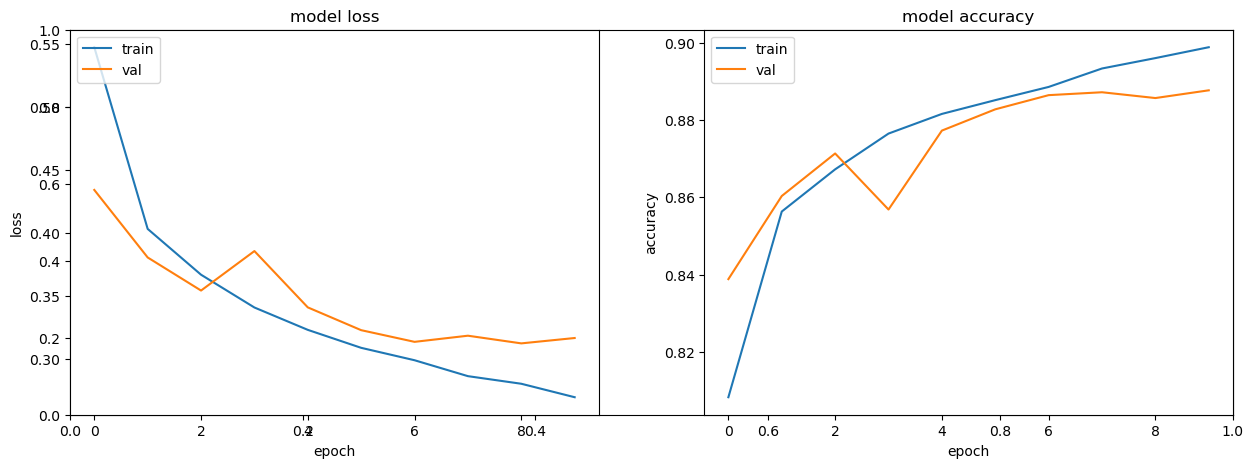

In [15]:
plot_graphs(best_model_history)

#### Retrain the model with optimal number of epochs

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7587 - loss: 0.6940 - val_accuracy: 0.8519 - val_loss: 0.4173
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8529 - loss: 0.4093 - val_accuracy: 0.8621 - val_loss: 0.3880
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8652 - loss: 0.3679 - val_accuracy: 0.8752 - val_loss: 0.3427
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8754 - loss: 0.3406 - val_accuracy: 0.8758 - val_loss: 0.3349
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8848 - loss: 0.3157 - val_accuracy: 0.8751 - val_loss: 0.3361
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8829 - loss: 0.3126 - val_accuracy: 0.8784 - val_loss: 0.3309
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8876 - loss: 0.3004 - val_accuracy: 0.8842 - val_loss: 0.3165
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8962 - loss: 0.2771 - 

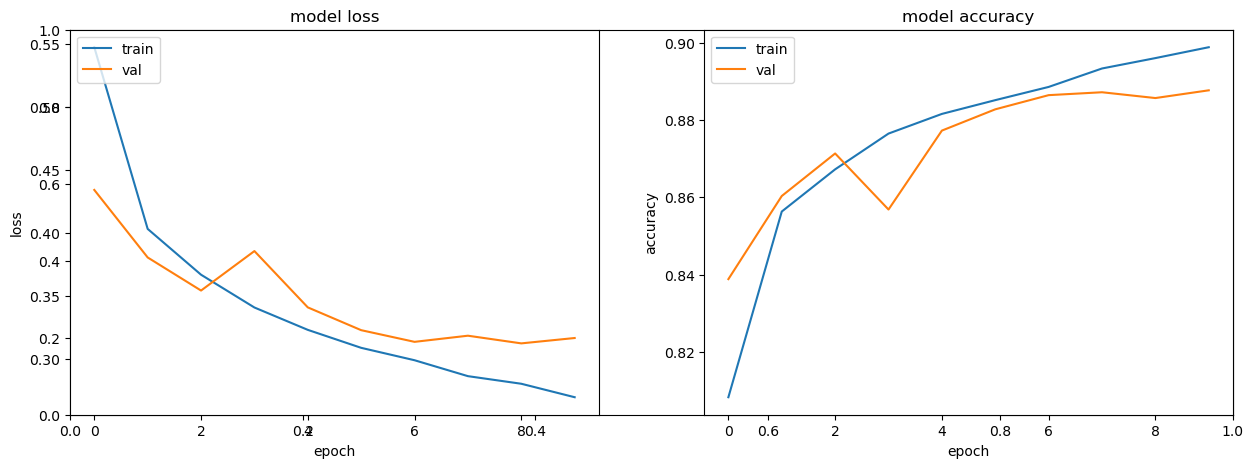

In [17]:
# Plot graphs
plot_graphs(best_model_history)

#### Evaluate the Model

In [18]:
eval_result = hypermodel.evaluate(img_test, label_test)
print(f'[test loss, test accuracy]: {eval_result}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - accuracy: 0.8791 - loss: 0.3289
[test loss, test accuracy]: [0.33459609746932983, 0.8808000087738037]


The `my_dir/intro_to_kt` directory contains detailed logs and checkpoints for every trial (model configuration) run during the hyperparameter search. If you re-run the hyperparameter search, the Keras Tuner uses the existing state from these logs to resume the search. To disable this behavior, pass an additional overwrite=True argument while instantiating the tuner.